# Customer Spending Model

## Conteúdo

1. **[Introdução](#04-introduction)**
- **[Questões Iniciais](#04-init-quest)**
- **[Análise Exploratória dos Dados](#04-eda)**
    1. **[Distribuição de Gastos Mensais](#04-monthly-spendings)**
    - **[Análise de Padrão de Gastos e Limites](#04-patterns)**
- **[Metricas](04-#metrics)**
- **[Feature Enginnering](#feat-eng)**
- **[Modeling](#modeling)**

# Introdução <a name="01-introduction"></a>
Neste notebook, nós iremos explorar o problema de modelagem do padrão de gasto dos clientes. Nós começaremos por definir o problema que queremos modelar e em seguida passaremos a buscar uma variável *target* adequada ao problema. Em seguida, apresentaremos uma análise exploratória dos dados que, esperamos, nos dê alguns *insights* para a modelagem posterior. Na seção 4, faremos uma análise do relacionamento das métricas utilizadas no modelo com as métricas de performance de negócio e em seguida, apresentaremos a etapa de criação de caracterísicas utilizadas na modelagem. Por fim, apresentaremos o modelu final obtido e seus resultados.

## Modelagem de gastos dos clientes
O problema consiste em predizer o padrão de gastos dos clientes. O objetivo é discriminar os clientes, no momento em que eles solicitam um cartão de crédito, em relação à expectativa de seu comportamento gastos. Nós queremos identificar clientes com padrão de gastos elevados já que ele são mais lucrativos para o negócio. No momento da solicitação, só temos acesso a um conjunto de informções provido pelo próprio solicitante ou por provedores externos. Essas informações incluem dados geográficos, de renda e de modelagem de crédito.

Para iniciar, vamos formular algumas questões relacionadas ao problema em questão

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")


import sys, os
sys.path.insert(0,os.path.realpath('..'))
pd.options.display.max_columns = 50

import src.data_util as du
import src.pipeline_transformers as pp
main_color = (97/255, 47/255, 116/255, 1.)

In [2]:
acquisition_train, spend_train = du.load_data_preprocessed('../data')
raw_acquisition_train, raw_spend_train, _ = du.load_data('../data')
numeric_encoder = pp.NumericEncoder()
acquisition_train[du.QUALITATIVE_VARS] = numeric_encoder.fit_transform(acquisition_train[du.QUALITATIVE_VARS]).fillna(-1)
acquisition_train['ids'] = raw_acquisition_train['ids']

Loading formatted geocoded file...


# Questões Iniciais <a name="03-init-quest"></a>
Antes de iniciar a exploração própriamente dita, vamos formular algumas questões para serem respondidas no curso da análise. Mais questões surgirão naturalmente da nossa análise exploratória:

1. Devemos utlizar um modelo de classificação ou de regresssão?
2. Qual é uma variável alvo adequada ao problema?
3. Qual a relação entre as variáveis `credit_limit` e `spends` ?


### Definindo a abordagem
Nós começaremos respondendo à pergunta: devemos utilizar um modelo de classificação ou de regressão?

Nosso objetivo final, é discriminar clientes com padrão de alto consumo mensal que são mais lucrativos para o Nubank. Utilizando um *framework* de regressão, a análise de impacto no negócio seria feita posteriormente ao modelo e sobre as predições realizadas. Isso é, não imporíamos nenhuma premissa à priori e toda análise ficaria para o final da modelagem. Optamos, entretanto, por utilizar uma modelagem de classificação binária. Iremos impor um estrutura binária sobre os dados e a análise de impacto no negócio será feita sobre a previsão da variável binária. Dessa forma, dividimos a análise em duas etapas mais simples.

# Análise Exploratória dos Dados <a name="04-eda"></a>
A partir de agora, começaremos a análise exploratória dos dados, buscando *insights* para a etapa de modelagem.

### Distribuição de Gastos Mensais <a name="04-monthly-spendings"></a>
Nesta seção, vamos analisar a distribuição de gastos mensais dos clientes. Começaremos analisando um conjunto de variáveis que se diferenciam pelo número de meses em que são agregadas (média)

In [3]:
target = spend_train[['ids','spends']]
pv_3m = spend_train.groupby('ids')['spends'].rolling(3).sum().reset_index().rename(columns={'level_1':'index','spends':'pv_3m'})
pv_6m = spend_train.groupby('ids')['spends'].rolling(6).sum().reset_index().rename(columns={'level_1':'index','spends':'pv_6m'})
target = target.reset_index().merge(pv_3m, how='left', on=['ids','index']).set_index('index')
target = target.reset_index().merge(pv_6m, how='left', on=['ids','index']).set_index('index')
target['log_spends'] = np.log1p(target['spends'])
target['log_pv_3m'] = np.log1p(target['pv_3m'])
target['log_pv_6m'] = np.log1p(target['pv_6m'])

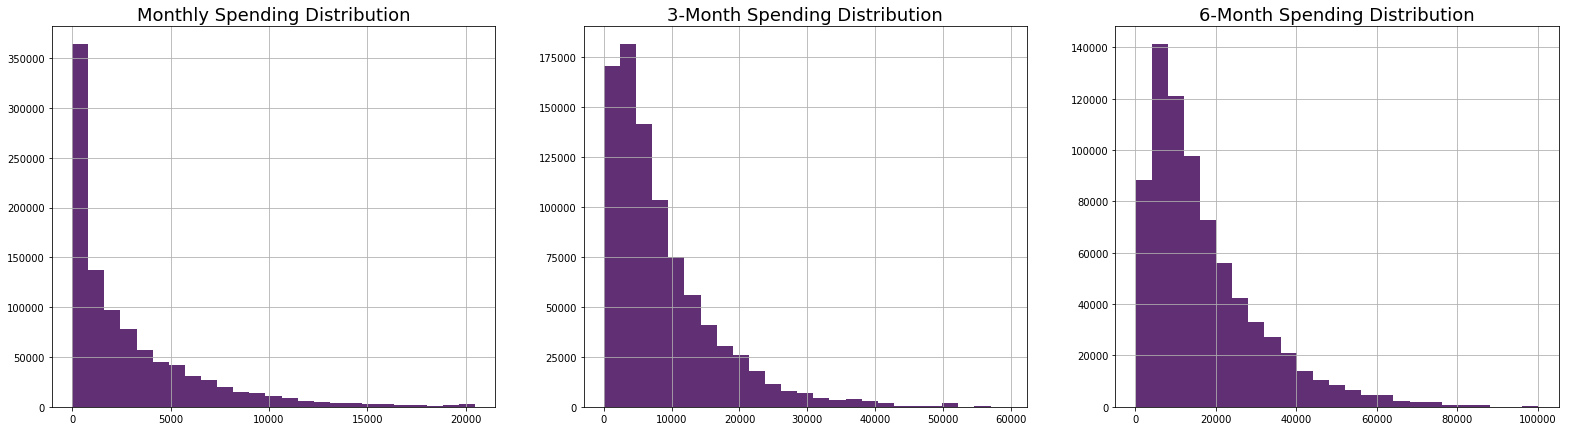

In [4]:
fig = plt.figure(figsize=(27,7))
ax = fig.add_subplot(131)
target['spends'].dropna().hist(bins=25, ax=ax, color=main_color)
_ = ax.set_title('Monthly Spending Distribution', fontdict={'fontsize':18})
ax = fig.add_subplot(132)
target['pv_3m'].dropna().hist(bins=25, ax=ax, color=main_color)
_ = ax.set_title('3-Month Spending Distribution', fontdict={'fontsize':18})
ax = fig.add_subplot(133)
_ = target['pv_6m'].dropna().hist(bins=25, ax=ax, color=main_color)
_ = ax.set_title('6-Month Spending Distribution', fontdict={'fontsize':18})

Como esperado, as variáveis de gasto seguem uma distribuição log-normal. Como um clinete não pode ter um gasto negativo, a calda negativa da distribuição é cortada. A distribuição log-normal aparece frequentemente em variáveis aleatórias com significado de preço, como em *asset pricing*, por exemplo.  
Observado esse comportamento, nós podemos esperar encontrar uma distribuição "mais comportada" tomando-se o logaritmo natural das variáveis anteriores:

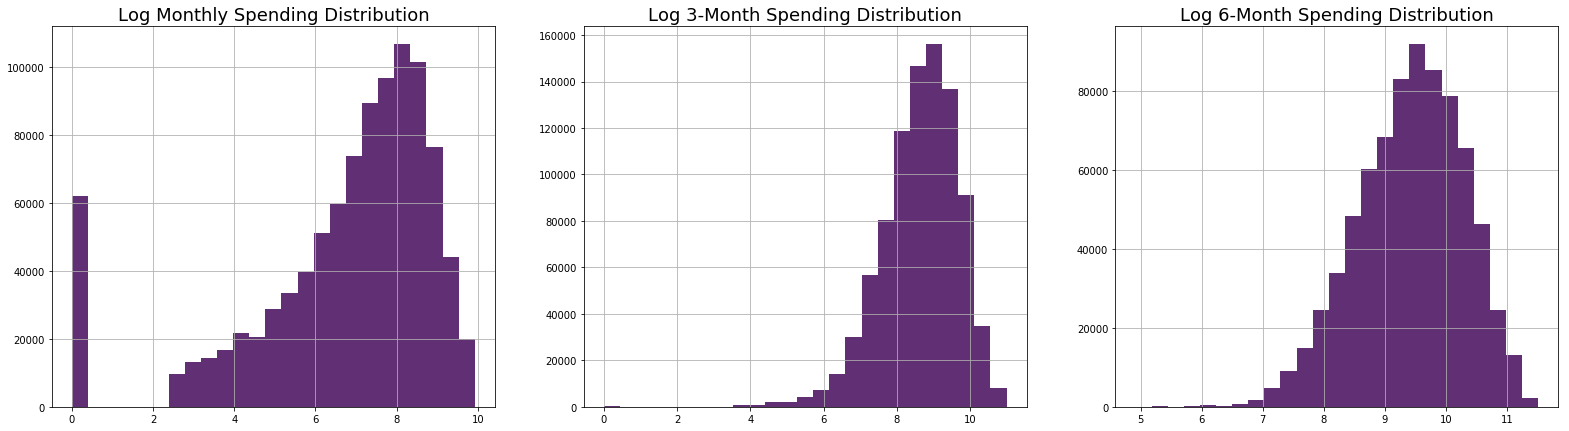

In [5]:
fig = plt.figure(figsize=(27,7))
ax = fig.add_subplot(131)
target['log_spends'].dropna().hist(bins=25, ax=ax, color=main_color)
ax.set_title('Log Monthly Spending Distribution', fontdict={'fontsize':18})
ax = fig.add_subplot(132)
ax.set_title('Log 3-Month Spending Distribution', fontdict={'fontsize':18})
target['log_pv_3m'].dropna().hist(bins=25, ax=ax, color=main_color)
ax = fig.add_subplot(133)
target['log_pv_6m'].dropna().hist(bins=25, ax=ax, color=main_color)
_ = ax.set_title('Log 6-Month Spending Distribution', fontdict={'fontsize':18})

Perceba que nós estamos tomando o log após a agregação de gastos mensais. Aplicar o log antes, traria dificuldades na transformada inversa caso queiramos utilizar essas variáveis em nossa modelagem.  
A primeira observação é a de que agregar longos períodos leva a distribuições mais próximas de uma distribuição normal. (Aqui, não realizaremos testes de normalidade nem nos preocuparemos com o momentos de mais alta ordem da distribuição). Outro efeito benéfico da agregação de mais longo período é a suavização de efeitos de sazonalidade, como aumento de gastos nos períodos de final de ano.

**Nesse momento, cogitamos utilizar o logaritmo natural da média de gastos mensais nos primeiros 12 meses após o recebimento do cartão de crédito**. A opção de utilização apenas dos 12 primeiros meses se dá pois queremos eliminar qualquer efeito de mudança da distribuição de gastos com o passar do tempo. Apesar de não estarmos lidando com um problema de séries temporais, a variável que utilizaremos como target possui uma dimensão temporal, a dos meses.  
Mais à frente, na análise exploratória, teremos a oportunidade de verificar se essa é uma boa escolha para a modelagem

In [6]:
target_spends = spend_train.loc[spend_train['month']<=12,:].groupby('ids')['spends'].mean().to_frame(name='target_spends').reset_index()
target_spends['target_spends'] = (target_spends['target_spends']>=target_spends['target_spends'].mean()).astype(np.uint8)

## Análise do Padrão de Gastos e Limites <a name="04-patterns"></a>

Nesta seção queremos entender como o gasto mensal dos clientes se relaciona com as variáveis fornecidas no momento da solicitação do cartão. Observe que todos os valores de gasto e rotativo utilizados nesta seção já foram previamente ajustados para a taxa de inflação.  
Adicionaremos em nossa análise a variável `credit_line`. Essa variável se refere ao limite aprovado pelo Nubank ao seus clientes e nossa hipótese é que ela guarda forte relão com o padrão de gastos. Podemos utilizá-la para obter *insights* em nossa modelagem futura.  
Nossa primeira análise será da relação entre o padrão de gastos e as variáveis de renda e crédito informados pelo solicitando e obtidos de provedores externos

In [7]:
monthly_spend = spend_train.loc[spend_train['month']<=12,:].groupby('ids')['credit_line','spends'].mean().reset_index()
monthly_spend = monthly_spend.merge(raw_acquisition_train[['ids','income','reported_income','credit_limit','last_amount_borrowed']], how='left',on='ids')
monthly_spend['reported_income'] = monthly_spend['reported_income'].replace(np.inf,np.nan)
display(monthly_spend.describe())

,credit_line,spends,income,reported_income,credit_limit,last_amount_borrowed
count,45000.000000,45000.000000,4.443800e+04,4.493300e+04,31200.000000,15044.000000
mean,6441.681511,2852.460161,7.160739e+04,1.032542e+13,34381.951154,13782.341991
std,4556.101062,2134.275025,5.185897e+04,2.559648e+14,36586.982218,8077.571933
min,506.000000,12.296667,4.821180e+03,4.030000e+02,0.000000,1005.180000
25%,2949.000000,1201.752308,4.501078e+04,5.085600e+04,10000.000000,7519.502500
50%,5302.000000,2260.326154,6.126676e+04,1.016300e+05,25647.000000,12023.465000
75%,8737.000000,3932.665192,8.601923e+04,1.511870e+05,47086.750000,19220.270000
max,20484.000000,15705.142000,5.000028e+06,6.355500e+15,448269.000000,35059.600000


Na tabela acima, notamos a presença de *outliers* na variável `reported_income`. O valor médio declado de dez trilhões de reais parece exagerado

Vamos começar eliminando os *outilier* da variável `reported_income`. Esse procedimento será incorporado na função de carregamento de dados e, assim, utilizado nos outros modelos. Vamos realizar um procedimento simples de eliminação dos *outiliers* que tem valor acima da média dos dados acrescida de 3 desvios padrão da amostra (isso é, manteremos mais de 99% das observações, no caso de uma variável normal).  
Aqui cabe uma importante observação, da tabela acima percebemos que as estatísticas da variável `reported_income` está extremamente distorcida devido a valores extremos dos *outliers*. Utilizaremos, por isso, a média e desvio padrão da variável `income` como um *proxy* das estatísticas verdadeiras:


In [8]:
monthly_spend.loc[monthly_spend['reported_income']>monthly_spend['income'].mean()+monthly_spend['income'].std()*3,:].head()

,ids,credit_line,spends,income,reported_income,credit_limit,last_amount_borrowed
6,00141481-d30b-2cb1-fefc-dae26098bda6,6704,3326.726154,96029.73,6.355500e+15,28466.0,NaN
43,00409195-8ead-465d-67a6-7b59e0857677,17244,5483.602308,31020.64,6.355500e+15,20722.0,NaN
91,0086008c-d1e2-2355-99eb-37ad481d3bfc,940,533.803077,40010.31,1.300000e+06,45422.0,NaN
358,020b1924-aa75-940f-a4c3-22eb2c3959da,4072,2266.708462,110028.91,5.550000e+07,58091.0,NaN
378,02214c89-06e4-0d91-c54b-4f9282112761,5828,3041.888333,110016.42,6.355500e+15,0.0,21010.28


Identificamos os valores extremos na variável `reported_income`. Vamos eliminá-los e verificar novamente as estatísticas:

In [9]:
monthly_spend.loc[monthly_spend['reported_income']>monthly_spend['income'].mean()+monthly_spend['income'].std()*3,:] = np.nan
monthly_spend.loc[monthly_spend['income']>monthly_spend['income'].mean()+monthly_spend['income'].std()*3,:] = np.nan
display(monthly_spend.describe())

,credit_line,spends,income,reported_income,credit_limit,last_amount_borrowed
count,44212.000000,44212.000000,43653.000000,44145.000000,30652.000000,14765.000000
mean,6440.354564,2852.709976,68818.326211,100407.545996,33826.067271,13684.493533
std,4555.241428,2135.019932,34605.006716,57567.581415,35453.525530,8000.821761
min,506.000000,12.296667,4821.180000,403.000000,0.000000,1005.180000
25%,2949.750000,1201.752308,44762.110000,50520.000000,10000.000000,7515.160000
50%,5298.000000,2259.829231,60325.970000,100945.000000,25415.500000,12022.210000
75%,8737.250000,3932.866154,85026.100000,150197.000000,46565.750000,19024.050000
max,20484.000000,15705.142000,227361.480000,200000.000000,448269.000000,35059.600000


Notamos que as variáveis `credit_line`, `spends` tem interpretação de valores mensais enquanto `income` e `reported_income` tem interpretação anual. As variáveis `credit_limit` e `last_amount_borrowed` representam valores absolutos sem dimensão temporal.
Vamos iniciar outra análise, verificando como a varíável `credit_line` se comporta em relação às outras:

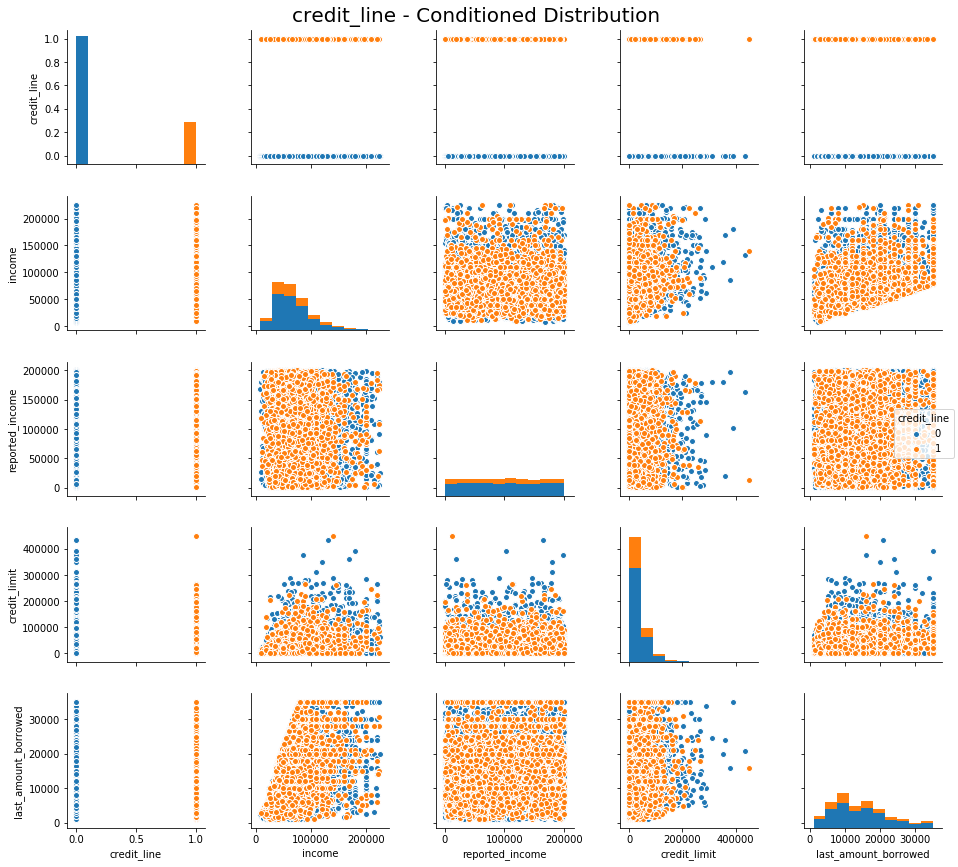

In [27]:
data = monthly_spend[['credit_line','income','reported_income','credit_limit','last_amount_borrowed']].dropna().astype(np.float32)
data['credit_line'] = (data['credit_line'] >data['credit_line'].quantile(0.75)).astype(np.uint8)
sns.pairplot(data, hue='credit_line')
plt.suptitle('credit_line - Conditioned Distribution', fontsize=20)
_=plt.tight_layout(rect=[0, 0.02, 1, 0.97])

Nos *scatter plots* acima, estamos discriminando duas classes: a primeira representa os 75% com menor limite de cartão de crédito, a segunda classe indica os 25% com maior linha de crédito. Apesar da baixa separabilidade dos dados, notamos um curioso padrão. A linha de crédito fornecida pelo Nubank tem valores maiores nas regiões em que as variáveis `income` e `credit_limit` são menores.  
Possívelmente, a partição quantílica não é uma boa variável para prever a linha de crédito aprovada pelo Nubank Nós queremos prever o padrão de consumo, e já chegaremos lá. Antes, verificaremos como a variável `credit_line` se comporta em relação ao gasto mensal médio

-3.4178300318034536

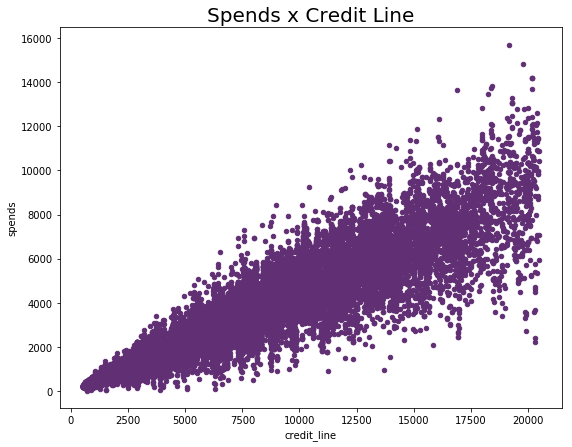

In [11]:
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)
data = monthly_spend[['credit_line','spends','income']].dropna()
data.plot.scatter(x='credit_line',y='spends', ax=ax, color=main_color)
_ = ax.set_title('Spends x Credit Line', fontsize=20)
from sklearn.metrics import r2_score
display(r2_score(data[['spends']],data[['credit_line']]))

De fato, o limite de crédito alocado pelo Nubank reflete muito bem o padrão de consumo de seus clientes. Isso reforça nossa hipótese de a simples partição quantílica dos dados não ser adequada ao problema. Vamos, nesse caso, tentar normalizar a variável por uma base comum à todos os clientes. Utilizaremos a partição quantílica mas, dessa vez, sobre o quociente da variável de gasto mensal pela variável `income`:

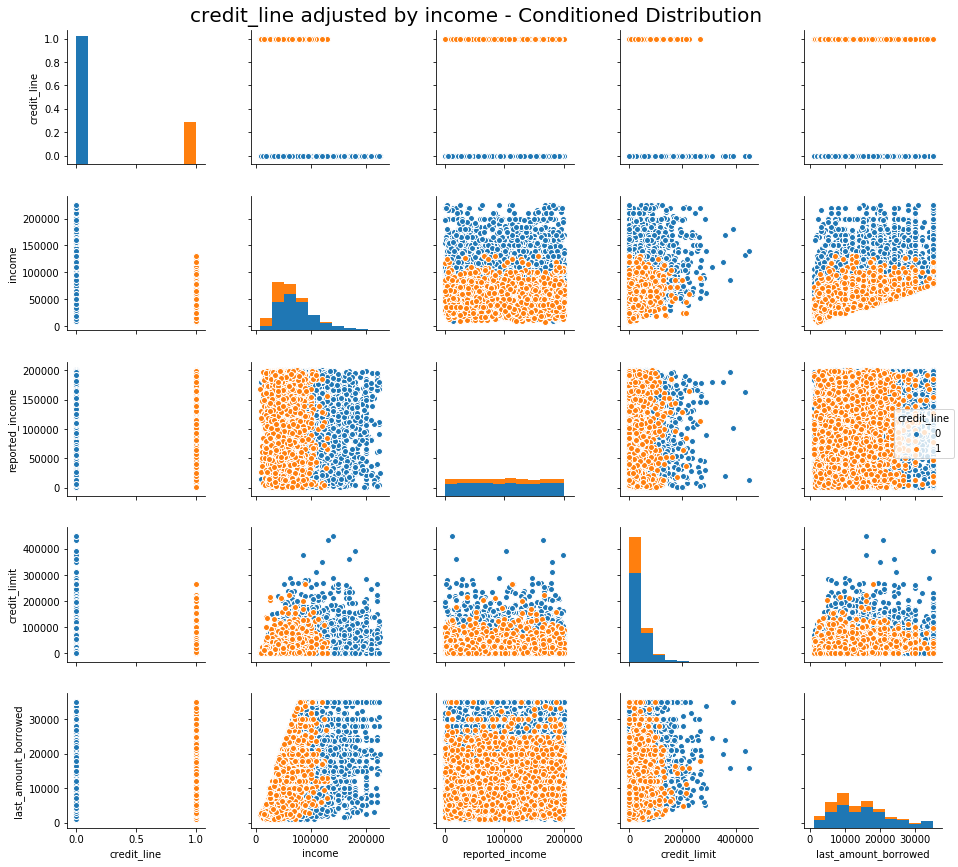

In [29]:
data = monthly_spend[['credit_line','income','reported_income','credit_limit','last_amount_borrowed']].dropna().astype(np.float32)
data['credit_line'] /= (data['income'])
data['credit_line'] = (data['credit_line'] >data['credit_line'].quantile(0.75)).astype(np.uint8)
sns.pairplot(data, hue='credit_line')
plt.suptitle('credit_line adjusted by income - Conditioned Distribution', fontsize=20)
_=plt.tight_layout(rect=[0, 0.02, 1, 0.97])

Observe que agora temos uma variável mais separável nos dados analisados. A interpretação aqui é: a primeira classe representa os 75% de clientes que gastam o gastam o menor percentual mensal em relação a sua renda (`income`), enquanto a segunda classe representa os 25% os clientes com maior gasto percentual em relação à sua renda.  
Observe que transformamos o problema de prever um valor financeiro de gasto mensal para a previsão de um valor percentual de gasto mensal, em relação à renda do cliente.
**Chegamos a conclusão de que devemos alterar nossa variável target. Utilizaremos como target para o nosso problema de regressão essa variável do gasto médio mensal nos primeiros 12 meses após o recebimento do cartão de crédito normalizada pela renda do cliente**. Com essa o valor esperado dessa variável *target*, podemos facilmente, utilizando a variável `ìncome`, obter o padrão de consumo em valores monetários.

Vamos repetir as análises das variáveis de `spends` e `credit_line` ajustadas para `income`:

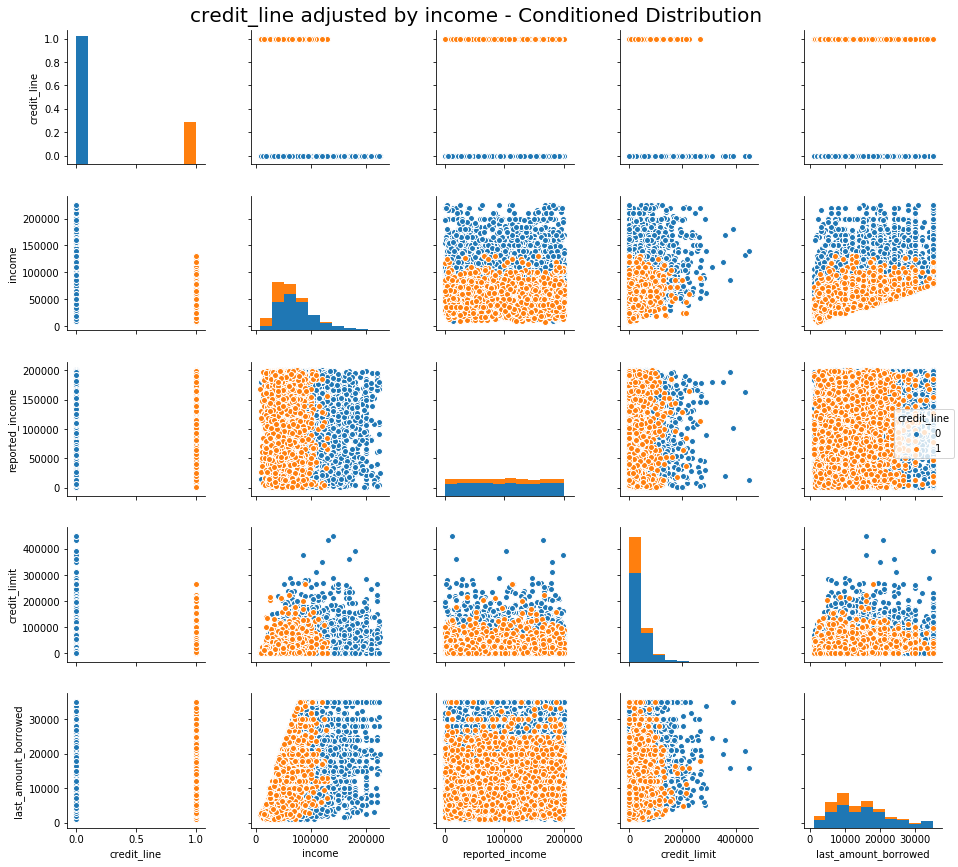

In [47]:
data = monthly_spend[['credit_line','income','reported_income','credit_limit','last_amount_borrowed']].dropna().astype(np.float32)
data['credit_line'] /= (data['income'])
data['credit_line'] = (data['credit_line'] >data['credit_line'].quantile(0.75)).astype(np.uint8)
sns.pairplot(data, hue='credit_line')
plt.suptitle('credit_line adjusted by income - Conditioned Distribution', fontsize=20)
_=plt.tight_layout(rect=[0, 0.02, 1, 0.97])

R-square: -20695725032.517


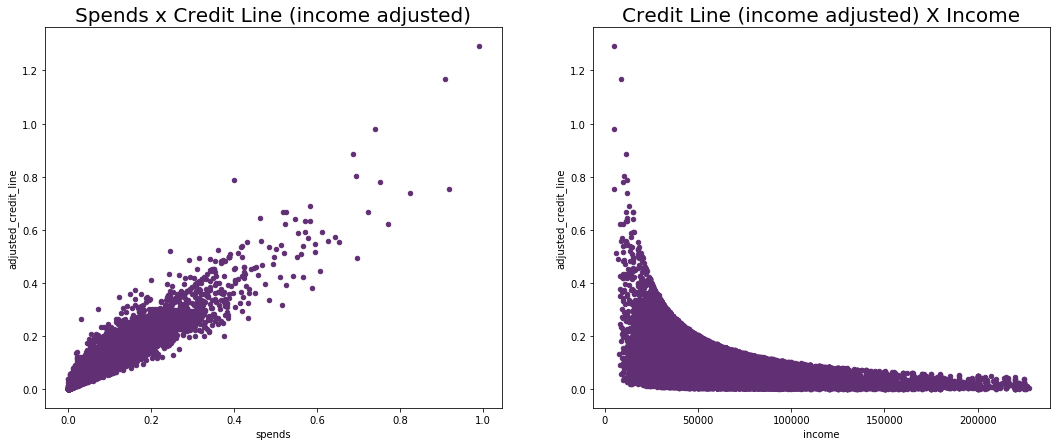

In [45]:
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(121)
data = monthly_spend[['credit_line','spends','income']].dropna()
data['spends'] /= data['income']
data['adjusted_credit_line'] = data['credit_line']/data['income']/2
data.plot.scatter(y='adjusted_credit_line',x='spends', ax=ax, color=main_color)
_ = ax.set_title('Spends x Credit Line (income adjusted)', fontsize=20)
print("R-square: {:.3f}".format(r2_score(data[['spends']],data[['credit_line']])))
ax = fig.add_subplot(122)
data.plot.scatter(y='adjusted_credit_line',x='income', ax=ax, color=main_color)
_ = ax.set_title('Credit Line (income adjusted) X Income', fontsize=20)

O gráfico acima (esquerda) ilustra o resultado que desejamos obter. Nesse caso, nosso modelo de regressão deve estimar uma variável análoga a `credit_line` ajustada pelo `income`. No gráfico da direita podemos observar a distribuição de nossa variável *target* condicionada ao `income`.

# Métricas <a name="04-metrics"></a>

Nese problema, utilizaremos um modelo de regressão. A métrica usual, e que será utilizada aqui, para esse tipo de modelo é o *$R^2$ score*. Nós já temos um *benchmark* dado pela própria modelagem para definição de limite de crédito do Nubank.

# Modelagem <a name="model"></a>
Nesta seção, descreveremos o modelo usados, o procedimento de treinamente e os resultados obtidos. Nós começamos por responder de forma concisa e objetiva o questionário pedido na seção **Tarefas** no Projeto Nubank, no portal da Udacity. Em seguida, seguiremos com uma análise mais profunda:

- **O que se está tentando prever?**  
Estamos tentando prever o percentual médio de gastos dos clientes em relação à sua renda mensal. Queremos, por exemplo, discrmininar os cliente que gastam, na média, 20% do seu orçamento mensal dos que gastam 80%. Como a variável de renda `income` é informada no momento da predição, tendo o valor esperado do consumo percentual da renda do cliente, podemos converter essa variável para o valor monetário.

- **Qual foi o target (variável alvo) escolhido? Se optou-se por um modelo não supervisionado, qual o motivo?**  
A variável utilizada como *target*, foi o logaritmo natural da média mensal dos 12 primeiros meses do cliente no Nubank dividido pela variável `income`. (na verdade foi adicionado um ao quociente antes da tomada do log para evitar problema de indeterminação).

- **Quais variáveis foram selecionadas e qual foi o critério de seleção?**  
O critério de seleção de variáveis se dá, primeiro pela indicação de importância que os modelos baseados em àrvores de decisão possuem. Segundo, pelo monitoramente das métricas em experimentos com validação cruzada (*cross-validation*). A lista completa das variáveis selecionadas é apresentada à seguir.

- **Quais as variáveis mais importantes do seu modelo?**  
As variáveis de maior importância foram as associadas a renda e crédito, `income`, `reported_income`, `credit_limit` e as variáveis criadas com suas interações.

- **Quais métricas foram selecionadas para a validação do modelo? O que cada uma delas significa de acordo com o contexto do que se está tentando prever? Quais evidências te fariam crer ou não de que a performance de validação será a mesma de quando este modelo estiver rodando de fato com novos dados?**  
Como discutido na seção **Métricas**, nós utilizamos a,étrica $R^2$ para avaliação da performance. Ela fornece o grau perfeição de *fitting* no sentido da norma euclidiana. A interpretação usual é o percentual de variância dos dados explicado pelo modelo. Durante o processo de treinamento, nós tivemos o cuidado de fazer do modelo um caso repodutível e confiável. Nós usamos validação cruzada estratificada para a seleção de variáveis e para estimar a performance do modelo. Além disso, em todas as transformações dos dados de entradas, nós nos preocupamos em evitar vazamento de dados (*data leakage*) e separamos uma fração de dados que se manteve intocada durante o processo de treinamente e foi usada ao final para termos uma validação de todo o processo.


## O modelo
Nós construímos um *framework* para realização de experimentos de *machine learning* fortemente baseado no paradigmo utilizado pelo *scikit_learn*. Dessa forma, pudermos testar variados modelos daquele pacote sem nenhum esforço além do de configurar os hiperparâmetros. Apesar disso, acamos por utilizar um modelo externo à bilbioteca, o LighGBM, mantido pela *Microsoft*.  
Esse modelo é largamente utilizado na modelagem de uma ampla classe de problema e, aqui, se mostrou superior às opções testadas do *scikit-learn*. O LightGBM siginifica, literalmente, *Light Gradient Boosting Machine*. Ele é uma *framework* para utilização de *ensemble* de árvores de decisão guiados por *gradient boosting*. Dessa forma, o estado final do modelo se caracteriza por um conjunto de árvores de decisão, potencialmente com milhares delas. Seus parâmetros de configuração permitem uma série de configurações avançadas para um treinamento robusto, como *bootstrapping*, regularizações, *bining* de variáveis, amostragem de *features*, entre outros.
O lightgbm tem uma tendência de *ovefitting* e por isso a fase de *tuning* dos hiperparâmetros foi importante. Nesta etapa, o conhecemento do comportamento dos parâmetros também é muito importante pois, devido ao grande número de parâmetros e valores aceitos, é impraticável realizar um *grid-search* de amplot espectro. Nossa abordagem foi realizar o acerto grosseiro baseado no conhecimento dos parâmetros e realizar o ajuste fino via *grid-search * com validação cruzada.  
No problema atual, nós utilizamos uma configuração de árvores de regressão. Utilizando a função de RMSE ($L^2$), o modelo crias as árvores de decisão e estima o resultado, nas folhas, através da média das obsevações classificadas  
A configuração de regressão se mostrou vantajosa neste problema uma vez que temos que estimar um limite de crédito para ser aprovado para o cartão de crédito. Isso é, queremos predizer uma variável contínua, caso típico em que utiliza-se regressão.

## Validação Cruzada
Validação cruzada é sempre um tema sensível em *machine learning*. As pontos que vamos discutir aqui dizem respeito ao número de divisões nos dados, estratégia de divisão e vazamento de dados.
Utilizamos uma validação cruzada com conjuntos (*5-Fold Cross Validation*). Um impeditivo de utilizar um número maior foi o forte *class imbalance* encontrado nesse problema. Muitos conjuntos na validação cruzada levaria o conjunto de validação a apresentar poucas observações positivas. *Class imabalance* também foi determinante na escolha da estratégia de divisão dos dados. Utilizamos uma validação cruzada estratificada, onde a distribuição das classes positivas é mantida em toda partição. Isso mitigou o efeito de *folds* com poucas observações positivas em relação aos outros.  
Por fim, a questão de vazamento de dados foi resolvida com o uso de uma arquitetura adequada para o *framework* de experimentação. Nosso *framework* trabalha em duas fases: *fit* e *trasform*. Na primeira, podemos utilizas os dados como bem entendermos pois só teremos acessos aos dados de treinamento. Na segunda etapa, dados de validação poderam estar presentes, então só poderemos realizar transformações em uma única observação ou utilizar estatísticas coletadas na etapa anterior.

## *Missing Values*
Outra característica interessante desse modelo é que ele aceita a entrada de dados com valores faltantes (NaN). Na prática o que acontece é que ele trata esses valores como uma classes distinta (no case de uma variável categórica) ou um valor distinto (no caso de uma variável contínua). Embora essa característica seja muito apreciada, em nosso pipeline nós implementamos utilizamos um módulo de para preenchimento de valores faltantes. Quatro estratégias são possíveis:
1. `constant`: Assim como no lightgbm, esse método preenche os dados faltantes com um valor distinto dos presentes nos dados
2. `mean`: Preenche os dados faltantes contínuos com a média dos dados existentes
3. `median`: Preenche os dados faltantes contínuos com a mediana dos dados existentes
4. `most_frequent`: Preenche os dados faltantes categóricos com a categoria mais frequente

No nosso problema, utilizamos a estratégia `constant` para dados categóricos e `mean` para dados continuos. Essa configuração apresentou melhor performance com validação cruzada.



In [51]:
metrics_df = pd.DataFrame(np.atleast_2d([0.86012,0.599583,0.591019]), columns=['Accuracy', 'AUC ROC', 'F-0.25'], index=['Credit_Risk'])
display(metrics_df)

,Accuracy,AUC ROC,F-0.25
Credit_Risk,0.86012,0.599583,0.591019


Conseguimos alguma melhora na precisão desse modelo. A distribuição natural dos dados apresenta forte desbalanceamento e já sai com precisão de 84% enquanto conseguimos  melhorar esse valor para 86%. A métrica *AUC ROC*, os diz que tivemos algum progresso (mas não muito) em relação ao chute completamente aleatório que tem AUCROC de 50%. Nosso modelo apresentou aproximadamente 60%. A métrica *F-025* tem valor absoluto menos interpretável, mas foi de extrema utilizade na